In [1]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
from skimage import transform


In [ ]:
def read_ru_mask(city):
    """
    Functions used in the paper
    Read the rural-urban mask from Urbclim for the city into numpay array. 
    The file has rural pixel as 1, urban pixel as Nan
    Flip the array to be in the same direction as the population file
    Dowscale it 10 times (from 100-m resolution to 1-km resolution) to be the same as the population file   

    """
    ru_file = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\rural_mask\\{city}.txt') 
    ru_mask = ru_file.copy()
    ru_mask[np.isnan(ru_mask)] = -1 # change urban pixel from Nan to -1 so that it is possible to calculate local mean and check whether urban/rural is dominant
    ru_mask = transform.downscale_local_mean(ru_mask[-1:0:-1, 0:-1], 10) # flip the rows and dowscale to 10 times lower 
    # check rural or urban is dominant: downscaled local mean > 0 -> rural is dominant, <=0 -> urban is dominant
    # set it back: rural is 1, urban is Nan
    ru_mask[ru_mask>0] = 1
    ru_mask[ru_mask<=0] = np.nan
    
    return ru_mask

def delta_exposure_daily_both(ax, city, month, thr, method, plot=True):
    """
    Functions used in the paper
    plot the difference in population (over urban pixels) exposed to temperature both below and above a defined threshold 

    Args:
        city (str): 
        month (list of int): [hot month, cold month]
        thr (str): 'MMT', 'RR11' 
        method (str): 'mean' or 'extreme' or 'both' cases of the temperature distributions
        plot (boolen):
    """
    
    # read the data
    day_pop_hot = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\\monthly_pop_array\\{month[0]}\\{city}_day.txt')
    night_pop_hot = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\\monthly_pop_array\\{month[0]}\\{city}_night.txt')
    day_pop_cold = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\\monthly_pop_array\\{month[1]}\\{city}_day.txt')
    night_pop_cold = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\\monthly_pop_array\\{month[1]}\\{city}_night.txt')
    ru_mask = read_ru_mask(city)
    cond = np.isfinite(np.array(day_pop_hot).flatten()-np.array(night_pop_hot).flatten()) # consider both rural and urban pixel
    # cond = np.isfinite(np.array(day_pop_hot).flatten()-np.array(night_pop_hot).flatten()) & np.isnan(ru_mask.flatten()) # only consider urban cells
    mean_tas_hot = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\July_meanT_2010to12\\{city}.txt') # read_temp(city, year, month[0])
    mean_tas_cold = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\Jan_meanT_2010to12\\{city}.txt') # read_temp(city, year, month[1])
    hottest = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\July_hottest3days_T_2010to12\\{city}.txt') # read_temp(city, year, month[0])
    coldest = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\Jan_coldest3days_T_2010to12\\{city}.txt') 
    MMT_file = pd.read_csv(f'C:\\Users\\glin\\Downloaded_data\\RRfit_zenodo\\MMT_urbclimT_{city.capitalize()}.csv', index_col=0)
    MMT = MMT_file['MMT'][2] # 45-65 year old
    RRfit = pd.read_csv(f'C:\\Users\\glin\\Downloaded_data\\RRfit_zenodo\\RRfit_urbclimT_{city.capitalize()}_45-65.csv', index_col=0)
    n_bins = 15
    if thr == 'MMT':
        thr_temp = MMT
    elif thr == 'RR11':
        RRfit = RRfit[(RRfit.index<14) & (RRfit.index > 3)] # only look at the cold side (below 14 Celcius degrees) and above 3 degrees because a few cities have downward curve on the cold sides 
        thr_temp = RRfit.index[np.argmin(abs(RRfit['allfit']-1.1))] # the cold temperature starting which the relative risk is higher than 1.1
    if method == 'mean':
        n_hot, bins_hot = np.histogram(np.array(mean_tas_hot).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_hot).flatten()-np.array(night_pop_hot).flatten())[cond]);
        n_cold, bins_cold = np.histogram(np.array(mean_tas_cold).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_cold).flatten()-np.array(night_pop_cold).flatten())[cond]);
    elif method == 'extreme':
        n_hot, bins_hot = np.histogram(np.array(hottest).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_hot).flatten()-np.array(night_pop_hot).flatten())[cond]);
        n_cold, bins_cold = np.histogram(np.array(coldest).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_cold).flatten()-np.array(night_pop_cold).flatten())[cond]);
    elif method=='both':
        # for the case of mean temperature
        n_hot_mean, bins_hot_mean = np.histogram(np.array(mean_tas_hot).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_hot).flatten()-np.array(night_pop_hot).flatten())[cond]);
        n_cold_mean, bins_cold_mean = np.histogram(np.array(mean_tas_cold).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_cold).flatten()-np.array(night_pop_cold).flatten())[cond]);  
        diff_cold_mean = int(np.nansum((day_pop_cold-night_pop_cold)[(mean_tas_cold<thr_temp)]))
        # in the case of extreme temperature 
        n_hot_extreme, bins_hot_extreme = np.histogram(np.array(hottest).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_hot).flatten()-np.array(night_pop_hot).flatten())[cond]);
        n_cold_extreme, bins_cold_extreme = np.histogram(np.array(coldest).flatten()[cond], bins=n_bins, weights = (np.array(day_pop_cold).flatten()-np.array(night_pop_cold).flatten())[cond]);
        diff_cold_extreme = int(np.nansum((day_pop_cold-night_pop_cold)[(coldest<thr_temp)]))
          
    # plot
    if plot==True:
        # fig, ax = plt.subplots(1,1,figsize=(4,3)) ### ax is in the arguments, so I can put the plot in the ax created outside the function
        ax.set_xlabel(f"T [$^\circ$C]")
        ax2 = ax.twinx()
        if method=='both':
            ax.bar(bins_hot_extreme[:len(bins_hot_extreme)-1], n_hot_extreme, width=0.2, color="red", hatch='////', label='hottest')
            ax.bar(bins_hot_mean[:len(bins_hot_mean)-1], n_hot_mean, width=0.2, color="red", label='July mean')
            # for graphical abstract remove the cold bins and add label='MMT'
            ax.bar(bins_cold_extreme[:len(bins_cold_extreme)-1], n_cold_extreme, width=0.2, color="cornflowerblue", hatch='////', label='coldest')
            ax.bar(bins_cold_mean[:len(bins_cold_mean)-1], n_cold_mean, width=0.2, color="cornflowerblue", label='Jan. mean')
            ax.set_xlim(bins_cold_extreme[0]-1,bins_hot_extreme[-1]+1)
            ax2.set_xlim(bins_cold_extreme[0]-1,bins_hot_extreme[-1]+1)

        else:
            ax.bar(bins_hot[:len(bins_hot)-1], n_hot, width=0.2, color="red")
            ax.bar(bins_cold[:len(bins_cold)-1], n_cold, width=0.2, color="red")
            if method=='mean':
                ax.set_xlim(bins_cold[0]-6,bins_hot[-1]+6)
                ax2.set_xlim(bins_cold[0]-6,bins_hot[-1]+6)
            elif (method=='extreme'):
                ax.set_xlim(bins_cold[0]-1,bins_hot[-1]+1)
                ax2.set_xlim(bins_cold[0]-1,bins_hot[-1]+1)
        ax.set_ylabel(r"$\rm \Delta P_{daily}$ (persons)") # \n {city.capitalize()}:{diff:,}       
        # ax2.plot(RRfit.index, RRfit.allfit, alpha=0.5, color='gray') # paper
        ax2.plot(RRfit.index, RRfit.allfit, alpha=0.5, color='gray', label='ERF') # poster   
        ax.plot(np.nan,  alpha=0.5, color='gray', label='ERF') 
        ax2.set_ylabel('Relative risk', color='gray') # paper

        ax2.tick_params(colors='gray')
        ax.axvline(MMT, linestyle='--', color='k', label='MMT')
        if thr=='RR11':
            ax.axvline(thr_temp, linestyle='--', color='k') # just for checking if the T(RR1.2) is taken correctly
        ax.axhline(0, color='gray')
        ax.set_title(f'{city.capitalize()}') # , mean:{diff_cold_mean:.0f}, extreme:{diff_cold_extreme:.0f}
        ax.legend(loc=9)
        return ax
    else:
        return diff_cold_mean, diff_cold_extreme

<AxesSubplot:title={'center':'London'}, xlabel='T [$^\\circ$C]', ylabel='$\\rm \\Delta P_{daily}$ (persons)'>

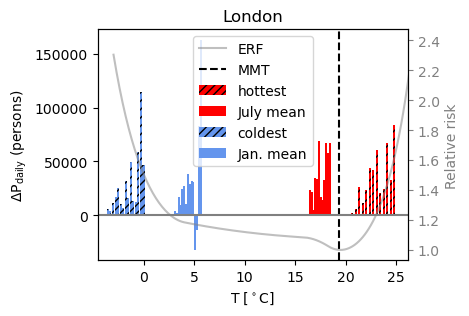

In [16]:
# Figure 5. a
city, month, thr, method = 'London', [7,1], 'MMT', 'both'
fig, ax = plt.subplots(1,1,figsize=(4,3))
delta_exposure_daily_both(ax, city, month, thr, method, plot=True)

<AxesSubplot:title={'center':'Athens'}, xlabel='T [$^\\circ$C]', ylabel='$\\rm \\Delta P_{daily}$ (persons)'>

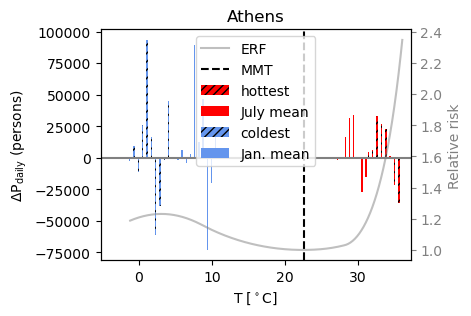

In [ ]:
# Figure 5. b
city, month, thr, method = 'Athens', [7,1], 'MMT', 'both'
fig, ax = plt.subplots(1,1,figsize=(4,3))
delta_exposure_daily_both(ax, city, month, thr, method, plot=True)

In [22]:
def delta_exposure_seasonal_both_new(ax, city, month, thr, method, plot=True):
    """
    Functions used in the paper
    plot the difference in population (over urban pixels) exposed to temperature above a defined threshold. Using the population difference between the hot and cold month, not annual mean population 

    Args:
        city (str): 
        month (list of int): [hot month, cold month]
        thr (str): 'MMT', 'RR11'
        method (str): 'mean', 'extreme', or 'both' cases of temperature distribuion to plot 
        plot (boolen):
    """
    # read the data
    night_pop_hot = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\{month[0]}\\{city}_night.txt')
    night_pop_cold = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\{month[1]}\\{city}_night.txt')
    ru_mask = read_ru_mask(city)
    cond = np.isfinite(np.array(night_pop_hot).flatten()) # consider both rural and urban pixels
    # cond = np.isfinite(np.array(night_pop_hot).flatten()) & np.isnan(ru_mask.flatten()) # only consider urban cells
    mean_tas_hot = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\July_meanT_2010to12\\{city}.txt') # read_temp(city, year, month[0])
    mean_tas_cold = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\Jan_meanT_2010to12\\{city}.txt') # read_temp(city, year, month[1])
    hottest = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\July_hottest3days_T_2010to12\\{city}.txt')
    coldest = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\Jan_coldest3days_T_2010to12\\{city}.txt')
    MMT_file = pd.read_csv(f'C:\\Users\\glin\\Downloaded_data\\RRfit_zenodo\\MMT_urbclimT_{city.capitalize()}.csv', index_col=0)
    MMT = MMT_file['MMT'][2] # 45-65 year old
    RRfit = pd.read_csv(f'C:\\Users\\glin\\Downloaded_data\\RRfit_zenodo\\RRfit_urbclimT_{city.capitalize()}_45-65.csv', index_col=0)
    n_bins = 15
    if thr == 'MMT':
        thr_temp = MMT
    elif thr == 'RR11':
        RRfit = RRfit[(RRfit.index<14) & (RRfit.index > 3)] # only look at the cold side (below 14 Celcius degrees) and above 3 degrees because a few cities have downward curve on the cold sides 
        thr_temp = RRfit.index[np.argmin(abs(RRfit['allfit']-1.1))] # the cold temperature starting which the relative risk is higher than 1.1
    if method == 'mean':
        n_hot, bins_hot = np.histogram(np.array(mean_tas_hot).flatten()[cond], bins=n_bins, weights = (np.array(night_pop_hot).flatten()-np.array(night_pop_cold).flatten())[cond]);
        n_cold, bins_cold = np.histogram(np.array(mean_tas_cold).flatten()[cond], bins=n_bins, weights = (np.array(night_pop_cold).flatten()-np.array(night_pop_hot).flatten())[cond]);
    elif method == 'extreme':
        n_hot, bins_hot = np.histogram(np.array(hottest).flatten()[cond], bins=n_bins, weights = (np.array(night_pop_hot).flatten()-np.array(night_pop_cold).flatten())[cond]);
        n_cold, bins_cold = np.histogram(np.array(coldest).flatten()[cond], bins=n_bins, weights = (np.array(night_pop_cold).flatten()-np.array(night_pop_hot).flatten())[cond]);
    elif method=='both':
        # for the case of mean temperature
        n_hot_mean, bins_hot_mean = np.histogram(np.array(mean_tas_hot).flatten()[cond], bins=n_bins, weights = (np.array(night_pop_hot).flatten()-np.array(night_pop_cold).flatten())[cond]); 
        diff_cold_mean = int(np.nansum((night_pop_cold-night_pop_hot)[(mean_tas_cold<thr_temp)]))
        # in the case of extreme temperature 
        n_hot_extreme, bins_hot_extreme = np.histogram(np.array(hottest).flatten()[cond], bins=n_bins, weights = (np.array(night_pop_hot).flatten()-np.array(night_pop_cold).flatten())[cond]);
        n_cold_extreme, bins_cold_extreme = np.histogram(np.array(coldest).flatten()[cond], bins=n_bins, weights = (np.array(night_pop_cold).flatten()-np.array(night_pop_hot).flatten())[cond]);
        diff_cold_extreme = int(np.nansum((night_pop_cold-night_pop_hot)[(coldest<thr_temp)]))
          
    # plot
    if plot==True:
        # fig, ax = plt.subplots(1,1,figsize=(4,3)) ###
        ax.set_xlabel(f"T [$^\circ$C]")
        ax2 = ax.twinx()
        width = 1
        if method=='both':
            ax.bar(bins_hot_extreme[:len(bins_hot_extreme)-1], n_hot_extreme, width=0.3, color="red", hatch='////')
            ax.bar(bins_hot_mean[:len(bins_hot_mean)-1], n_hot_mean, width=0.3, color="red")
            ax.set_xlim(bins_cold_extreme[0]-1,bins_hot_extreme[-1]+1)
            ax2.set_xlim(bins_cold_extreme[0]-1,bins_hot_extreme[-1]+1)
            
        elif (method=='mean') or (method=='extreme'):
            ax.bar(bins_hot[:len(bins_hot)-1], n_hot, width=0.2, color="red")
            ax.bar(bins_cold[:len(bins_cold)-1], n_cold, width=0.2, color="red")
            if method=='mean':
                ax.set_xlim(bins_cold[0]-6,bins_hot[-1]+6)
                ax2.set_xlim(bins_cold[0]-6,bins_hot[-1]+6)
            elif (method=='extreme'):
                ax.set_xlim(bins_cold[0]-1,bins_hot[-1]+1)
                ax2.set_xlim(bins_cold[0]-1,bins_hot[-1]+1)
        ax.set_ylabel("$\Delta$" + r"$\rm P_{seasonal}$ (persons)") 
        
        ax2.plot(RRfit.index, RRfit.allfit, alpha=0.5, color='gray')
        ax2.set_ylabel('Relative risk', color='gray') # paper
        ax2.tick_params(colors='gray')
        ax.axvline(MMT, linestyle='--', color='k')
        ax.axhline(0, color='gray')
        return ax
    else:
        return diff_cold_mean, diff_cold_extreme

<AxesSubplot:xlabel='T [$^\\circ$C]', ylabel='$\\Delta$$\\rm P_{seasonal}$ (persons)'>

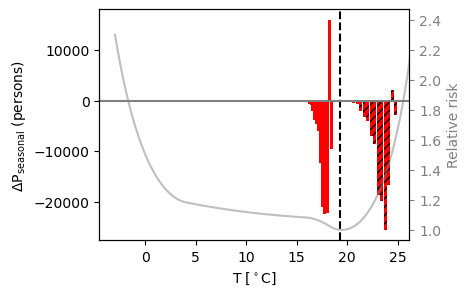

In [23]:
# Figure 5. c
city, month, thr, method = 'London', [7,1], 'MMT', 'both'
fig, ax = plt.subplots(1,1,figsize=(4,3))
delta_exposure_seasonal_both_new(ax, city, month, thr, method, plot=True)

<AxesSubplot:xlabel='T [$^\\circ$C]', ylabel='$\\Delta$$\\rm P_{seasonal}$ (persons)'>

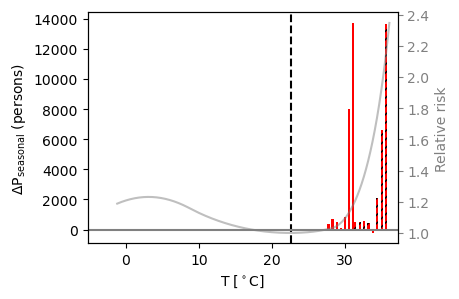

In [24]:
# Figure 5. d
city, month, thr, method = 'Athens', [7,1], 'MMT', 'both'
fig, ax = plt.subplots(1,1,figsize=(4,3))
delta_exposure_seasonal_both_new(ax, city, month, thr, method, plot=True)